# Image Offsets: Find stars

This notebook combines the procedures developed in `Background.ipynb` and `White_light_images.ipynb` notebooks to build images suitable for star finding. Then it applies `photutils` tools to find star images and build  tables with centroid locations. 

There is also a statistical analysis to see how star shapes depend on the RGB normalization coefficients. 

Later we proceed to find stars in a few contiguous images in the sequence, to see how:
 - to correlate the detections that are stored in separate tables;
 - to keep track of the offsets from each n-th image to the reference n=0 image
 
There is code to save the offsets table to a FITS file.
 
No flat field, bias, or dark calibrations are required here. Note that, for the Sony Alpha camera used to get these data sets, they are not likely to be ever needed.

In [1]:
# %matplotlib widget

import os

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from astropy.table import Table
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

from photutils import centroids
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.background import Background2D, MedianBackground, ModeEstimatorBackground

import rawpy

from datapath import DATA

In [2]:
# 1st test image - this will be the reference image against with subsequent images
# will have their offsets computed. We need it here at the top of the script so
# its size can be known from the start.
# fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03779.ARW')
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03770.ARW')
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

In [3]:
# parameters to control background subtraction
bkg_cell_footprint = (100, 100)
bkg_filter = (9, 9)

bkg_sigma_clip = SigmaClip(sigma=5.)
bkg_kernel = Gaussian2DKernel(x_stddev=1)
bkg_estimator = ModeEstimatorBackground()

# parameters for star finding
dao_fwhm = 4.5
dao_threshold = 2000.
sharplo = 0.1
sharphi = 1.0
roundlo = -0.9 
roundhi = 0.9

In [4]:
# masks that isolate the RGB pixels - these are camera-dependent and work with all images
colors_array = raw.raw_colors_visible

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

## Functions

In [5]:
def subtract_background(imarray, red_norm=1.0, blue_norm=1.0):

    # red_norm and blue_norm are normalization parameters applied to the R and B bands (assume
    # G=1) in order to make the star images as well-behaved as possible, in terms of being 
    # well represented, on average, by the daofind Gaussian. Ideally a different normalization 
    # should be applied to each star, depending on its color index, but this will be left as
    # a possible (but not very likely) future improvement. For now, we assume that an average,
    # frame-wide single normalization should suffice (statistically).
    
    # separate color bands
    red_array = imarray * red_mask
    green_array = imarray * green_mask
    blue_array = imarray * blue_mask
    
    # interpolate over the masked pixels in each band, so the background estimator 
    # is presented with a smooth array entirely filled with valid data
    red_array[red_array == 0.0] = np.nan
    green_array[green_array == 0.0] = np.nan
    blue_array[blue_array == 0.0] = np.nan

    red_array = interpolate_replace_nans(red_array, bkg_kernel)
    green_array = interpolate_replace_nans(green_array, bkg_kernel)
    blue_array = interpolate_replace_nans(blue_array, bkg_kernel)

    red_array[np.isnan(red_array)] = 0.
    green_array[np.isnan(green_array)] = 0.
    blue_array[np.isnan(blue_array)] = 0.
    
    # fit background model to each smoothed-out color band
    red_bkg = Background2D(red_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    green_bkg = Background2D(green_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)
    blue_bkg = Background2D(blue_array, bkg_cell_footprint, filter_size=bkg_filter, sigma_clip=bkg_sigma_clip, bkg_estimator=bkg_estimator)

    # subtract background from each masked color array
    subtracted = imarray - red_bkg.background * red_mask - \
                           green_bkg.background * green_mask - \
                           blue_bkg.background * blue_mask

    # after background subtraction, apply color band normalization. This has to be done separately
    # from step above for the background on each band to remain zero on average.
    subtracted = (subtracted * red_mask * red_norm) + \
                 (subtracted * green_mask) + \
                 (subtracted * blue_mask * blue_norm)

    return subtracted, red_bkg

In [6]:
class CentroidFinder():
    def __init__(self, x_estimate, y_estimate, size, sky, threshold):
        self.x_estimate = x_estimate
        self.y_estimate = y_estimate
        self.sky = sky
        self.threshold = threshold
        self.size = int(size * 2) + 1
        
        self.result = Table()
        
    def find(self, image):
        x, y = centroids.centroid_sources(image, self.x_estimate, self.y_estimate, 
                                          box_size=self.size, centroid_func=centroids.centroid_com)                

        self.result.add_column(x, name='xcentroid')
        self.result.add_column(y, name='ycentroid')

        return self.result                

## Process first image

In [7]:
subtracted, red_bkg = subtract_background(imarray, red_norm=1.38, blue_norm=1.43)

22658.651796158334
Relative standard deviation of a smooth patch:  10.882200480493927


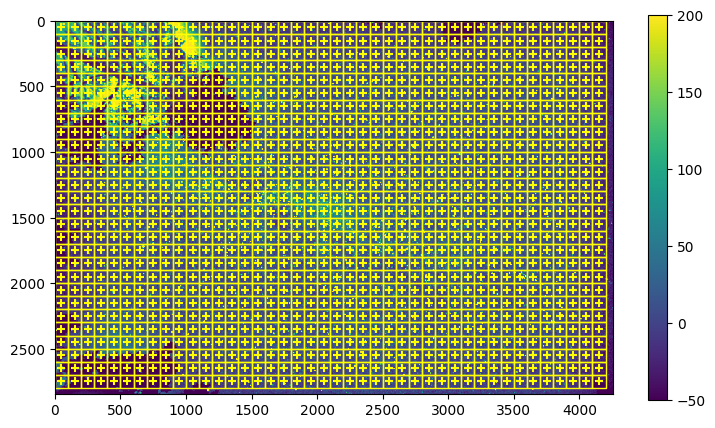

In [ ]:
plt.figure(figsize=[9, 5])
print(np.max(subtracted))
plt.imshow(subtracted, vmin=-50, vmax=200)
red_bkg.plot_meshes(outlines=True, color='yellow')
plt.colorbar()

section = subtracted[750:810,3320:3380]
print("Relative standard deviation of a smooth patch: ", np.std(section) / np.median(section))

In [9]:
# find star images. For the first image, we use daofind.
global_median = np.median(subtracted)
daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                        sharplo=sharplo, sharphi=sharphi,
                        roundlo=roundlo, roundhi=roundhi)
sources = daofind(subtracted)  
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2419.181068429604,14.99218282044368,0.5887618106626946,0.07376196968136475,0.2470399389686706,25,-1.373556984539421,3863.14996515391,36.824971624086,-3.91535605216022
2,2084.4319102908958,25.04113171435161,0.8763861578741373,0.18421803490048408,0.08614562630072882,25,-1.373556984539421,12539.690927333357,40.12407944227729,-4.008512704016721
3,63.33128134375134,28.91689663173794,0.6247561563094299,-0.4076499502311384,-0.3648774846119276,25,-1.373556984539421,3728.5574471353107,36.08938299859403,-3.893448643040392
4,3261.1450013887734,30.29410949050747,0.9256375451686792,-0.2027873629236286,-0.03794135514474557,25,-1.373556984539421,3732.534041531668,36.00697701584684,-3.890966653716592
5,1680.672808638345,34.9104585188366,0.7412062307626879,0.49426112525607147,0.09218690844608964,25,-1.373556984539421,2332.7576209353388,35.53773746855326,-3.8767244368245253
6,4145.08853697284,42.984613086594834,0.6963522101696069,-0.22243828692421133,-0.02561802615806707,25,-1.373556984539421,1796.8647376785432,35.34367407971562,-3.8707792342913456
7,1854.969679704413,49.56599249967911,0.6212878857491425,0.5965007857389338,0.625840668576304,25,-1.373556984539421,5853.484733938402,37.85257439170372,-3.9452385541140513
8,1188.931115119258,53.172763230531075,0.954326664924594,0.33030541887341025,-0.15045479454165167,25,-1.373556984539421,8132.343247213719,37.74360252461048,-3.9421083750976216
9,2815.976649354568,71.50522007522994,0.3585429138688151,-0.15203636452268798,0.21235523583152183,25,-1.373556984539421,1791.684671544614,35.96604641374089,-3.8897317509915936


In [10]:
# statistics
print("Mean roundness: ", np.average(sources['roundness1']), "stdev: ", np.std(sources['roundness1']))
print("Mean sharpness: ", np.average(sources['sharpness']), "stdev: ", np.std(sources['sharpness']))

Mean roundness:  -0.042368915481610994 stdev:  0.25609146148533585
Mean sharpness:  0.6967382446599163 stdev:  0.22114875157828343


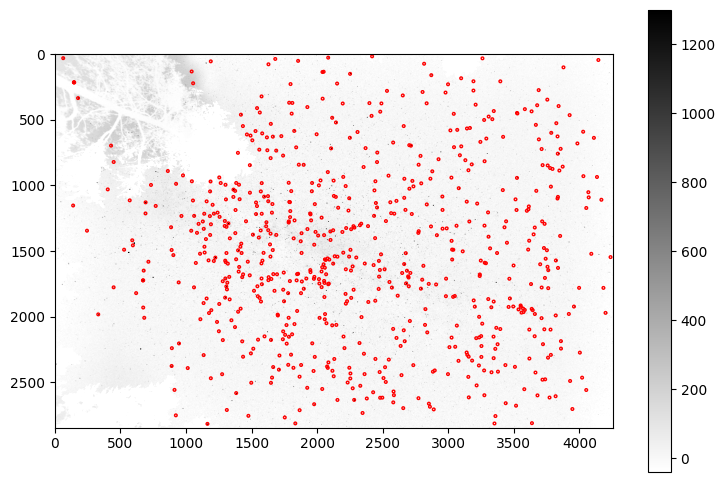

In [ ]:
positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]
apertures = CircularAperture(positions, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap = apertures.plot(color='red')

## Statistical analysis

These notebook cells (normally not executed) are used to find optimal R and B normalization factors that would minimize roudness (or maximize sharpness).

In [ ]:
# optimization functions
def stats(table):
    mean_roundness = np.average(table['roundness1'])
    mean_sharpness = np.average(table['sharpness'])
    stdev_roundness = np.std(table['roundness1'])
    
    print(mean_roundness, mean_sharpness, stdev_roundness)

#     return abs(stdev_roundness)    # min roundness stdev
    return abs(mean_roundness)    # zero roundness
#     return 1./ mean_sharpness   # maximum shapness

def objective_function(coeffs):
    
    red_norm = coeffs[0]
    blue_norm = coeffs[1]
    
    subtracted, _ = subtract_background(imarray, red_norm=red_norm, blue_norm=blue_norm)
    
    global_median = np.median(subtracted)
    daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                            sharplo=sharplo, sharphi=sharphi,
                            roundlo=roundlo, roundhi=roundhi)
    sources = daofind(subtracted)
    
    return stats(sources)  

In [13]:
# raw = rawpy.imread(fname)
# imarray = raw.raw_image_visible.astype(float)

# res = minimize(objective_function, (1.3, 1.3), method='Nelder-Mead', tol=1.5e-2)
# print(res.x, res.fun)

In [14]:
# subtract background from each masked color array, but now with the optimized normalization
# factors that make the star images the roundest. 
subtracted, red_bkg = subtract_background(imarray, red_norm=1.60, blue_norm=1.39)

In [15]:
# find stars 
global_median = np.median(subtracted)
daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                        sharplo=sharplo, sharphi=sharphi,
                        roundlo=roundlo, roundhi=roundhi)

sources = daofind(subtracted)  

print("# detections: ", len(sources))
print("Mean roundness: ", np.average(sources['roundness1']), "stdev: ", np.std(sources['roundness1']))
print("Mean sharpness: ", np.average(sources['sharpness']), "stdev: ", np.std(sources['sharpness']))

# detections:  743
Mean roundness:  -0.04534551850922599 stdev:  0.25550063788063687
Mean sharpness:  0.7056762480516635 stdev:  0.20772280654854103


## Correlate two contiguous images

In [16]:
# this is the next image after the test image used at the beginning of the notebook
# fname2 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03780.ARW')
fname2 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03771.ARW')
raw2 = rawpy.imread(fname2)
imarray2 = raw2.raw_image_visible.astype(float)

In [17]:
subtracted2, _ = subtract_background(imarray2, red_norm=1.60, blue_norm=1.39)

In [18]:
global_median = np.median(subtracted2)

# provide positions
x_estimate = sources['xcentroid']
y_estimate = sources['ycentroid']
# positions = [(x,y) for x,y in zip(x_estimate, y_estimate)]

# we have been using DAOStarFinder for all steps, but it fails in reproducing 
# the same detections on image pairs. Lets try instead a hands-on approach with 
# a simpler substitute. 
# daofind = DAOStarFinder(xycoords=np.array(positions), fwhm=dao_fwhm, 
#                         sky=global_median,
#                         threshold=dao_threshold,
#                         sharplo=sharplo, sharphi=sharphi,
#                         roundlo=roundlo, roundhi=roundhi) 
# sources2 = daofind(subtracted2)

starfinder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2, global_median, dao_threshold)
sources2 = starfinder.find(subtracted2)

sources2


xcentroid,ycentroid
float64,float64
2422.394501545458,17.24048565826702
2083.4992719845413,25.25568396606804
63.20214625436684,29.748080016795996
3242.572844160527,40.78057263805312
1678.4778018799104,35.31657719177193
4163.696552677854,50.654192245338
1854.1545162416717,50.510205121659936
1188.6679528892396,53.79579359272252
2814.5268249510823,72.25392849678683


In [19]:
global_median

-1.4141286170995984

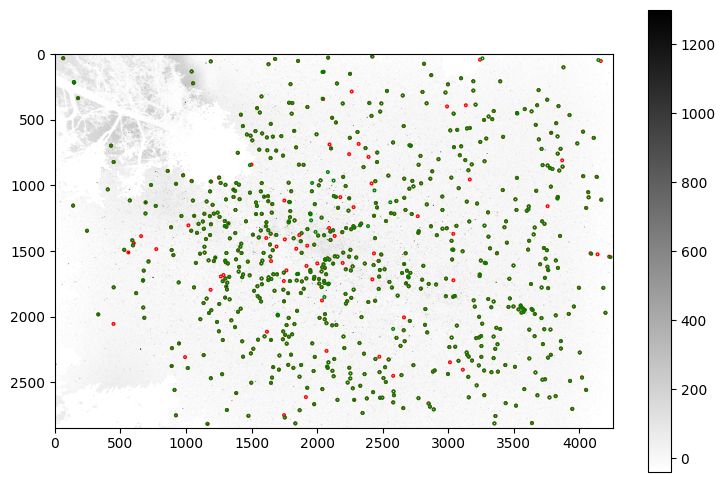

In [20]:
# plot positions from both first and second images
positions2 = [(x,y) for x,y in zip(sources2['xcentroid'], sources2['ycentroid'])]
apertures2 = CircularAperture(positions2, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted2, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap2 = apertures2.plot(color='red')
ap_ = apertures.plot(color='green') # first image

### Build table with offsets in star positions

First thing to do is to find each pair of stars, one in each table.

For that, we use the centroid positions: for every star in the first table, look for the one star in the second table whose position differs by less than 1.5 pixel (in both X and Y coords).

We also need to store two pointers in the second table. To allow navigation in the list of tables associated to a set of images:

 - the row number of the same star in the reference (first) table.
 - the row number of the same star in the *previous* image in the sequence.
 
The reference image won't have neither of these columns. In the 2nd table in the sequence, these columns will be redundant.

In [21]:
sources2.add_column(np.nan, name='xoffset')
sources2.add_column(np.nan, name='yoffset')
sources2.add_column(0, name='ref_row')
sources2.add_column(0, name='prev_row') # redundant for the 2nd image in sequence

for row_index in range(len(sources)):
    x = sources[row_index]['xcentroid']
    y = sources[row_index]['ycentroid']
    
    for row2_index in range(len(sources2)):
        x2 = sources2[row2_index]['xcentroid']
        y2 = sources2[row2_index]['ycentroid']
        x_off = x2 - x
        y_off = y2 - y
        if abs(x_off) <= 1.5 and abs(y_off) <= 1.5:
            sources2[row2_index]['xoffset'] = x_off
            sources2[row2_index]['yoffset'] = y_off
            sources2[row2_index]['ref_row'] = row_index
            sources2[row2_index]['prev_row'] = row_index
            
            break # if there is another star that matches the criterion, just ignore it

In [22]:
sources2  

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2422.394501545458,17.24048565826702,nan,nan,0,0
2083.4992719845413,25.25568396606804,-0.9138485368630427,0.22254263610613734,1,1
63.20214625436684,29.748080016795996,-0.12977049444211275,0.8435326311091416,2,2
3242.572844160527,40.78057263805312,nan,nan,0,0
1678.4778018799104,35.31657719177193,nan,nan,0,0
4163.696552677854,50.654192245338,nan,nan,0,0
1854.1545162416717,50.510205121659936,-0.8096760453831848,0.9227966640306278,6,6
1188.6679528892396,53.79579359272252,-0.2466453944211935,0.6245758039616263,7,7
2814.5268249510823,72.25392849678683,-1.446188007758792,0.7165792195371381,8,8


In [23]:
# stats
print(np.nanmean(sources2['xoffset']), np.nanstd(sources2['xoffset']))
print(np.nanmean(sources2['yoffset']), np.nanstd(sources2['yoffset']))
print(np.count_nonzero(~np.isnan(sources2['xoffset'])))

-0.3715162393864776 0.6092481726058331
-0.10128992664676999 0.5646545679155316
594


In [24]:
# keep only the NaN-free entries
has_nan = np.zeros(len(sources2), dtype=bool)
xoff = np.array(sources2['xoffset'])
has_nan |= np.isnan(xoff)
sources2_no_nan = sources2[~has_nan]

In [25]:
sources2_no_nan

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2083.4992719845413,25.25568396606804,-0.9138485368630427,0.22254263610613734,1,1
63.20214625436684,29.748080016795996,-0.12977049444211275,0.8435326311091416,2,2
1854.1545162416717,50.510205121659936,-0.8096760453831848,0.9227966640306278,6,6
1188.6679528892396,53.79579359272252,-0.2466453944211935,0.6245758039616263,7,7
2814.5268249510823,72.25392849678683,-1.446188007758792,0.7165792195371381,8,8
1629.3342334965232,74.52360337699726,0.521386516577877,-1.2845688390422794,9,9
3878.825520553278,98.6987223517392,-0.15515877783309406,-0.39762569466515174,10,10
1042.7592799183165,130.38974821719856,-0.3069314608856075,-0.10463878636846857,11,11
2250.3578828551686,148.75394431650082,-1.0409840028369217,0.11224215114921776,14,14


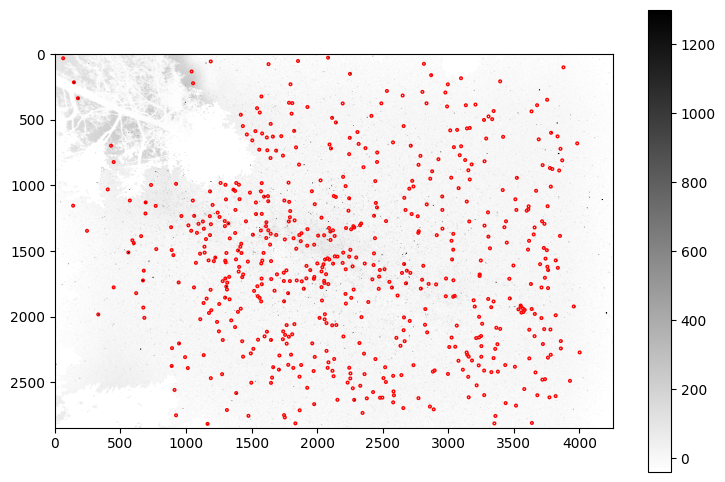

In [26]:
positions2_n = [(x,y) for x,y in zip(sources2_no_nan['xcentroid'], sources2_no_nan['ycentroid'])]
apertures2_n = CircularAperture(positions2_n, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted2, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap2_n = apertures2_n.plot(color='red')

## Add third image in sequence

The table associated to this image should contain offsets in relation to the first image. But to find star pairs, the code must use the second image. That is, the image immediately before it in the image time sequence.

We may want to add the image name (or path) to the table header.

In [27]:
# this is the next, third image 
# fname3 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03781.ARW')
fname3 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03772.ARW')
raw3 = rawpy.imread(fname3)
imarray3 = raw3.raw_image_visible.astype(float)

In [28]:
subtracted3, _ = subtract_background(imarray3, red_norm=1.60, blue_norm=1.39)

global_median = np.median(subtracted3)

# provide positions
x_estimate = sources2_no_nan['xcentroid']
y_estimate = sources2_no_nan['ycentroid'] 
# positions = [(x,y) for x,y in zip(x_estimate, y_estimate)]
# daofind = DAOStarFinder(xycoords=np.array(positions), fwhm=dao_fwhm, 
#                         sky=global_median,
#                         threshold=dao_threshold,
#                         sharplo=sharplo, sharphi=sharphi,
#                         roundlo=roundlo, roundhi=roundhi) 

starfinder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2, global_median, dao_threshold)
sources3 = starfinder.find(subtracted3)

In [29]:
sources3  

xcentroid,ycentroid
float64,float64
2082.7505657123033,25.404518467086326
62.00219518564337,30.111996879343856
1853.2608270623152,49.80606310573379
1187.8713982495906,54.24328879328372
2814.4947730344434,71.4061303831945
1626.991166472532,75.78671535373904
3877.132229827072,98.08435174043797
1042.3086822607588,130.3728243205816
2249.733656909717,148.72605177269136


Here we do the more general table operation to correlate the positions just gotten from the 3rd image, with the positions from the second image. But storing offsets in relation to the first (reference) image.

In [30]:
sources3.add_column(np.nan, name='xoffset')
sources3.add_column(np.nan, name='yoffset')
sources3.add_column(0, name='ref_row')
sources3.add_column(0, name='prev_row')

# loop over rows in 2nd table
for row_index2 in range(len(sources2_no_nan)):
    # get position in 2nd table, and index in 1st table
    x2 = sources2_no_nan[row_index2]['xcentroid']
    y2 = sources2_no_nan[row_index2]['ycentroid']
    ref_row = sources2_no_nan[row_index2]['ref_row']
    
    if ref_row == 0:
        continue

    # loop over rows in 3rd (newest) table
    for row_index3 in range(len(sources3)):
        x3 = sources3[row_index3]['xcentroid']
        y3 = sources3[row_index3]['ycentroid']
        
        # offsets in relation to 2nd table - these are the ones to check for proximity
        x32_off = x3 - x2
        y32_off = y3 - y2
        
        # offsets in relation to reference table
        x_ref = sources[ref_row]['xcentroid']
        y_ref = sources[ref_row]['ycentroid']
        x_off = x3 - x_ref
        y_off = y3 - y_ref

        if abs(x32_off) <= 1.5 and abs(y32_off) <= 1.5:
            sources3[row_index3]['xoffset'] = x_off
            sources3[row_index3]['yoffset'] = y_off
            
            # store pointers to rows in reference and previous tables
            sources3[row_index3]['ref_row'] = ref_row
            sources3[row_index3]['prev_row'] = row_index2
            
            break # if there is another star that matches the criterion, just ignore it

In [31]:
sources3  

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2082.7505657123033,25.404518467086326,-1.6625548091010387,0.3713771371244228,1,0
62.00219518564337,30.111996879343856,-1.3297215631655774,1.207449493657002,2,1
1853.2608270623152,49.80606310573379,-1.7033652247396276,0.21865464810448287,6,2
1187.8713982495906,54.24328879328372,-1.0432000340701961,1.0720710045228259,7,3
2814.4947730344434,71.4061303831945,-1.4782399243977125,-0.13121889405519482,8,4
1626.991166472532,75.78671535373904,nan,nan,0,0
3877.132229827072,98.08435174043797,nan,nan,0,0
1042.3086822607588,130.3728243205816,-0.7575291184432444,-0.12156268298542727,11,7
2249.733656909717,148.72605177269136,-1.6652099482885205,0.08434960733976027,14,8


In [32]:
# keep only the NaN-free entries
has_nan = np.zeros(len(sources3), dtype=bool)
xoff = np.array(sources3['xoffset'])
has_nan |= np.isnan(xoff)
sources3_no_nan = sources3[~has_nan]

In [33]:
sources3_no_nan  

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2082.7505657123033,25.404518467086326,-1.6625548091010387,0.3713771371244228,1,0
62.00219518564337,30.111996879343856,-1.3297215631655774,1.207449493657002,2,1
1853.2608270623152,49.80606310573379,-1.7033652247396276,0.21865464810448287,6,2
1187.8713982495906,54.24328879328372,-1.0432000340701961,1.0720710045228259,7,3
2814.4947730344434,71.4061303831945,-1.4782399243977125,-0.13121889405519482,8,4
1042.3086822607588,130.3728243205816,-0.7575291184432444,-0.12156268298542727,11,7
2249.733656909717,148.72605177269136,-1.6652099482885205,0.08434960733976027,14,8
2868.7457307109303,158.54194257785323,-2.0423381845193944,-0.009637582439808057,15,9
3396.1231879464067,205.46949032196756,-1.1342734204695262,-0.11827415588922463,18,11


In [34]:
# stats
print(np.nanmean(sources3_no_nan['xoffset']), np.nanstd(sources3_no_nan['xoffset']))
print(np.nanmean(sources3_no_nan['yoffset']), np.nanstd(sources3_no_nan['yoffset']))
print(np.count_nonzero(~np.isnan(sources3_no_nan['xoffset'])))

-0.764578152907435 0.7976793943418268
-0.10150318099999242 0.8393880818432239
566


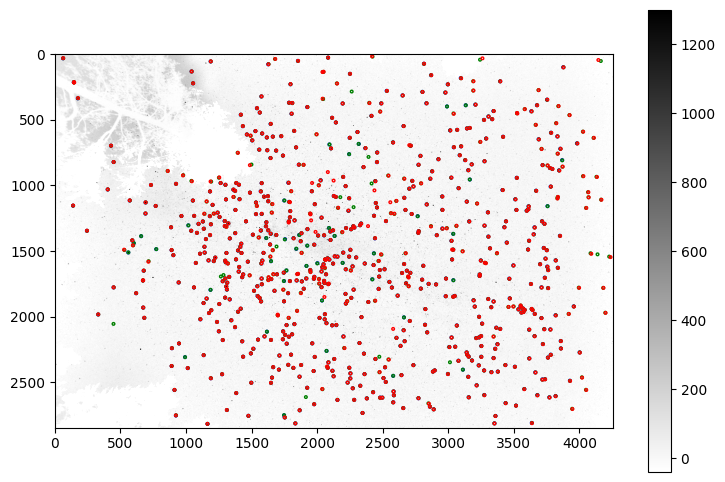

In [35]:
# plot positions from 3 images
positions3 = [(x,y) for x,y in zip(sources3['xcentroid'], sources3['ycentroid'])]
apertures3 = CircularAperture(positions3, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted3, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap3 = apertures3.plot(color='blue')
ap2 = apertures2.plot(color='green') 
ap1 = apertures.plot(color='red') 

## Save to file

In [36]:
sources3_no_nan.write('table.fits', format='fits', overwrite=True)

In [37]:
test = Table.read('table.fits')
test

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2082.7505657123033,25.404518467086326,-1.6625548091010387,0.3713771371244228,1,0
62.00219518564337,30.111996879343856,-1.3297215631655774,1.207449493657002,2,1
1853.2608270623152,49.80606310573379,-1.7033652247396276,0.21865464810448287,6,2
1187.8713982495906,54.24328879328372,-1.0432000340701961,1.0720710045228259,7,3
2814.4947730344434,71.4061303831945,-1.4782399243977125,-0.13121889405519482,8,4
1042.3086822607588,130.3728243205816,-0.7575291184432444,-0.12156268298542727,11,7
2249.733656909717,148.72605177269136,-1.6652099482885205,0.08434960733976027,14,8
2868.7457307109303,158.54194257785323,-2.0423381845193944,-0.009637582439808057,15,9
3396.1231879464067,205.46949032196756,-1.1342734204695262,-0.11827415588922463,18,11


## Add new sequence to existing one

The above steps worked on a single sequence of images (ISO 12800). Now, we add images from a different sequence (ISO 6400) to the existing sequence, keeping the same reference image.

In [38]:
# get image in 6400 sequence that is closest (in time) to reference image 
fname4 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/6400/light/DSC03769.ARW')
raw4 = rawpy.imread(fname4)
imarray4 = raw4.raw_image_visible.astype(float)

In [39]:
# process
subtracted4, _ = subtract_background(imarray4, red_norm=1.60, blue_norm=1.39)

global_median = np.median(subtracted4)

# provide positions - use original reference image from 12800 sequence 
x_estimate = sources['xcentroid']
y_estimate = sources['ycentroid']

starfinder = CentroidFinder(x_estimate, y_estimate, dao_fwhm*2, global_median, dao_threshold)
sources4 = starfinder.find(subtracted4)

In [40]:
sources4

xcentroid,ycentroid
float64,float64
2436.6807869856575,16.607913836826953
2090.6199420629887,24.846656612152593
65.95711263391235,29.015047773424094
3265.349742354912,26.658971977830447
1685.1602132110652,34.691453348570526
4132.149137026271,41.4986112389127
1860.487096941344,49.64476222075715
1195.9867843833133,52.47276346619757
2823.7189049619647,71.73040090772363


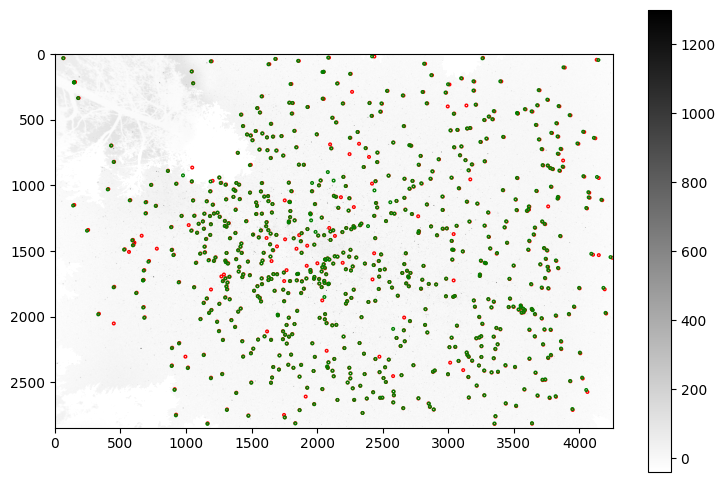

In [41]:
# plot positions from both reference image in 12800 sequence, and this image in 6400 sequence
positions4 = [(x,y) for x,y in zip(sources4['xcentroid'], sources4['ycentroid'])]
apertures4 = CircularAperture(positions4, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted4, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap4 = apertures4.plot(color='red')
ap_ = apertures.plot(color='green') # first image

### Build table with offsets

Same algorithm used previously (cell #21), but, with an extended range of 3.5 pixels. That should hopefully account for the jump in time between sequences, and at the same time prevent spurious pair detections.

In [42]:
sources4.add_column(np.nan, name='xoffset')
sources4.add_column(np.nan, name='yoffset')
sources4.add_column(0, name='ref_row')
sources4.add_column(0, name='prev_row') # redundant for the 2nd image in sequence

for row_index in range(len(sources)):
    x = sources[row_index]['xcentroid']
    y = sources[row_index]['ycentroid']
    
    for row4_index in range(len(sources4)):
        x4 = sources4[row4_index]['xcentroid']
        y4 = sources2[row4_index]['ycentroid']
        x_off = x4 - x
        y_off = y4 - y
        if abs(x_off) <= 3.5 and abs(y_off) <= 3.5:
            sources4[row4_index]['xoffset'] = x_off
            sources4[row4_index]['yoffset'] = y_off
            sources4[row4_index]['ref_row'] = row_index
            sources4[row4_index]['prev_row'] = row_index
            
            break # if there is another star that matches the criterion, just ignore it

In [43]:
sources4

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
2436.6807869856575,16.607913836826953,nan,nan,0,0
2090.6199420629887,24.846656612152593,nan,nan,0,0
65.95711263391235,29.015047773424094,2.6251958851033947,0.8435326311091416,2,2
3265.349742354912,26.658971977830447,nan,nan,0,0
1685.1602132110652,34.691453348570526,nan,nan,0,0
4132.149137026271,41.4986112389127,nan,nan,0,0
1860.487096941344,49.64476222075715,nan,nan,0,0
1195.9867843833133,52.47276346619757,nan,nan,0,0
2823.7189049619647,71.73040090772363,nan,nan,0,0


In [44]:
# stats
print(np.nanmean(sources4['xoffset']), np.nanstd(sources4['xoffset']))
print(np.nanmean(sources4['yoffset']), np.nanstd(sources4['yoffset']))
print(np.count_nonzero(~np.isnan(sources4['xoffset'])))

1.5041419195575072 1.2094634652762632
-0.1578747024136961 0.8183048367252507
554


In [45]:
# keep only the NaN-free entries
has_nan = np.zeros(len(sources4), dtype=bool)
xoff = np.array(sources4['xoffset'])
has_nan |= np.isnan(xoff)
sources4_no_nan = sources4[~has_nan]

In [46]:
sources4_no_nan

xcentroid,ycentroid,xoffset,yoffset,ref_row,prev_row
float64,float64,float64,float64,int64,int64
65.95711263391235,29.015047773424094,2.6251958851033947,0.8435326311091416,2,2
1044.263354245884,130.04405265843687,1.197142866682043,-0.10463878636846857,11,11
2049.8402328653156,133.3632464208815,0.04658972618744883,1.1459758283441488,12,12
150.8174141221985,211.44687433383442,3.491873456783651,-0.9871930664601791,21,21
1055.0079518238203,220.00492378305853,0.8107572612539116,-0.06317915840318733,22,22
2266.5806909835383,285.88620861538544,0.861577054774898,-0.6227596506481632,29,29
2046.7369249151195,337.9790300713848,-3.2762112056905153,-2.5843004211540688,36,36
2401.0585372463443,369.4749632883569,2.276845285537547,-2.2076843515874316,40,40
1565.9507852014267,443.53280638879,3.1001612134839434,0.2693023743318008,55,55


## Tests with Andromeda data set

In [47]:
# reference image 
fname = os.path.join(DATA,'astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03798.ARW')
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

In [79]:
# parameters to control background subtraction (identical as before)
bkg_cell_footprint = (100, 100)
bkg_filter = (9, 9)

bkg_sigma_clip = SigmaClip(sigma=5.)
bkg_kernel = Gaussian2DKernel(x_stddev=1)
bkg_estimator = ModeEstimatorBackground()

# parameters for star finding
dao_fwhm = 3.
dao_threshold = 700.
sharplo = 0.1
sharphi = 1.0
roundlo = -0.9 
roundhi = 0.9

In [80]:
# subtract background
subtracted, red_bkg = subtract_background(imarray, red_norm=1.38, blue_norm=1.43)

In [81]:
# find star images. For the first image, we use daofind.
global_median = np.median(subtracted)
daofind = DAOStarFinder(fwhm=dao_fwhm, sky=global_median, threshold=dao_threshold,
                        sharplo=sharplo, sharphi=sharphi,
                        roundlo=roundlo, roundhi=roundhi)
sources = daofind(subtracted)  
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,1557.3538856650482,4.633844232817397,0.5510872714097009,0.1284424811618856,-0.06824317145758828,25,-0.9234772959302973,816.5083396591896,24.31139313090151,-3.464524615508955
2,2856.2057278815096,9.6769157562219,0.4970400985673102,0.5420177214685021,-0.5863985273276275,25,-0.9234772959302973,774.6880816541058,24.201790038838325,-3.4596187223105384
3,2530.9326762589353,9.882098598094709,0.726071066826304,0.4345949974051386,0.023879124090418452,25,-0.9234772959302973,923.6024319244567,24.21835572490864,-3.4603616348128137
4,2857.7135366617827,11.037933043117086,0.8705455171936598,0.17484989995312328,-0.24597099210458168,25,-0.9234772959302973,2865.4048581101056,26.01171057172213,-3.5379222825881445
5,3373.8150218179517,28.225618679430227,0.8782238734421448,0.646766768827335,-0.19748818809463733,25,-0.9234772959302973,1297.0623288097888,24.36834212488837,-3.4670649585276143
6,3050.281234721351,34.37744278338586,0.11565535462403385,0.5087531584272525,-0.3031434914194761,25,-0.9234772959302973,3314.4572986868084,29.851740817836422,-3.6874241557100262
7,3265.9523335937206,35.18956467571651,0.7958090307564495,0.3304259244339788,-0.4257083260278476,25,-0.9234772959302973,2042.3226374624924,25.242349197890043,-3.505324425975032
8,1864.1498017645333,36.39378043060046,0.19920447412310624,0.572806664207119,-0.25255511638605,25,-0.9234772959302973,972.9255928670343,25.021513052892804,-3.4957839199336718
9,992.7286302421044,37.072402007209305,0.8547466663126264,0.27328743943104394,-0.6895141975268592,25,-0.9234772959302973,5874.718530486976,28.999325903380576,-3.655969756829747


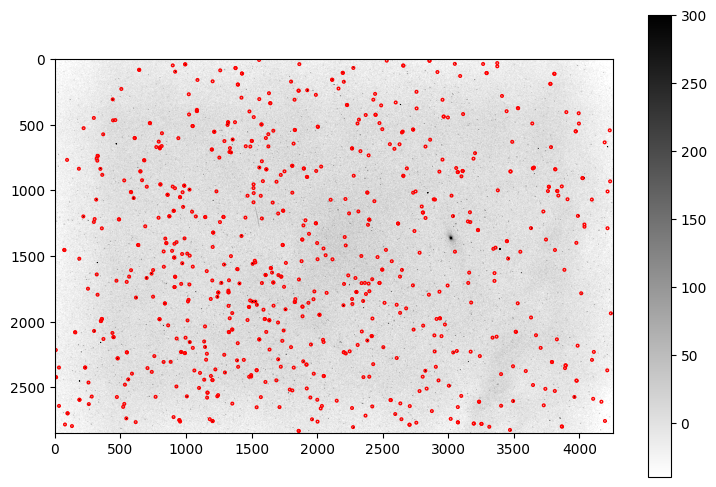

In [82]:
positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]
apertures = CircularAperture(positions, r=10.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted, vmin=-40, vmax=300, cmap='binary')
plt.colorbar()
ap = apertures.plot(color='red')